## NLP: classify disaster tweets

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing,metrics
from sklearn.linear_model import LogisticRegressionCV
#from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import re
import string


In [118]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission_df=pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

#train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")
#submission_file='sample_submission.csv'

In [119]:
print('Training Set Shape = {}'.format(train_df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_df.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_df.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [120]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [121]:
train_df.iloc[7612]

id                                                      10873
keyword                                                   NaN
location                                                  NaN
text        The Latest: More Homes Razed by Northern Calif...
target                                                      1
Name: 7612, dtype: object

In [122]:
idx_final_train_df=train_df.iloc[7612]['id']
print(idx_final_train_df)

10873


In [123]:
test_df.iloc[3262]

id                                                      10875
keyword                                                   NaN
location                                                  NaN
text        #CityofCalgary has activated its Municipal Eme...
Name: 3262, dtype: object

## Visualize target on training set

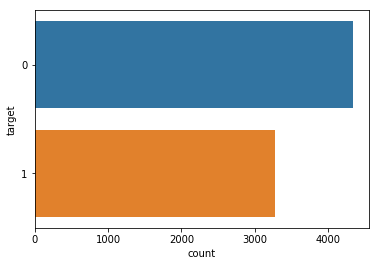

In [124]:
sns.countplot(y=train_df.target);


### Check and manage Missing Values

In [125]:
print('% of missing values for train dataset\n',train_df.isnull().sum()*100/len(train_df))
print('\n')
print('% of missing values for test dataset\n',test_df.isnull().sum()*100/len(train_df))

% of missing values for train dataset
 id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


% of missing values for test dataset
 id           0.000000
keyword      0.341521
location    14.514646
text         0.000000
dtype: float64


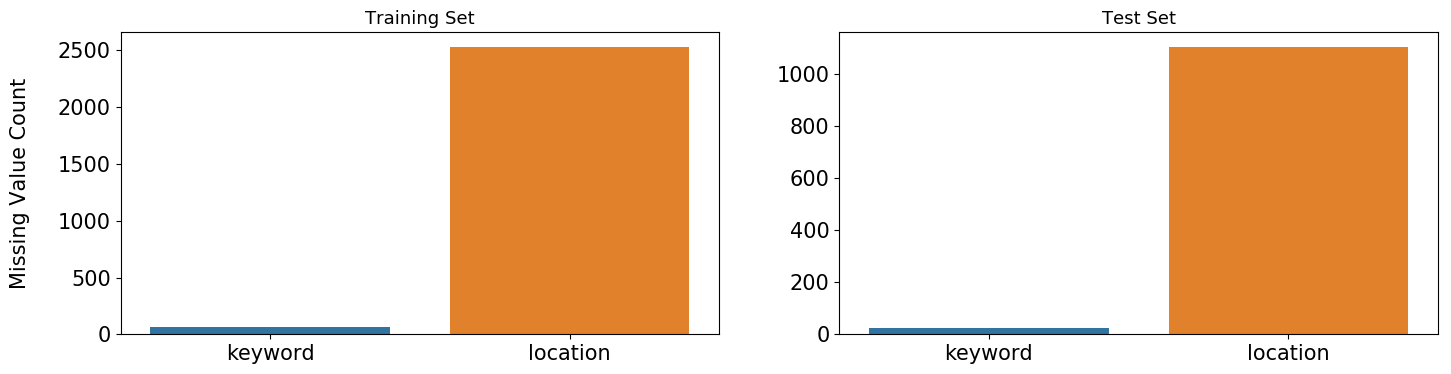

In [126]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_df[missing_cols].isnull().sum().index, y=test_df[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()


In [127]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

print('% of missing values for train dataset\n',train_df.isnull().sum()*100/len(train_df))
print('\n')
print('% of missing values for test dataset\n',test_df.isnull().sum()*100/len(train_df))


% of missing values for train dataset
 id          0.0
keyword     0.0
location    0.0
text        0.0
target      0.0
dtype: float64


% of missing values for test dataset
 id          0.0
keyword     0.0
location    0.0
text        0.0
dtype: float64


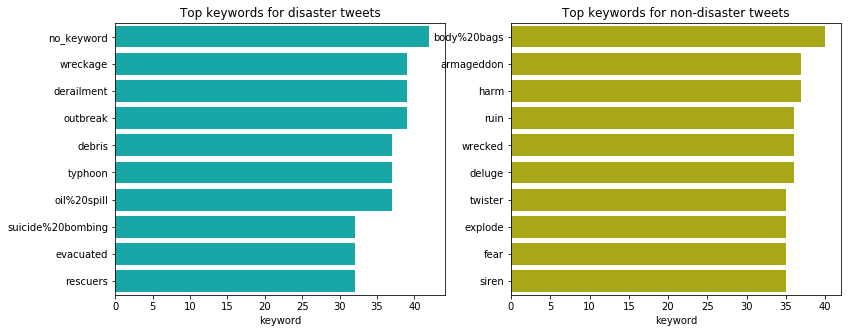

In [128]:
kw_dis=train_df[train_df['target']==1].keyword.value_counts().head(10)
kw_no_dis=train_df[train_df['target']==0].keyword.value_counts().head(10)
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_dis, kw_dis.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_no_dis, kw_no_dis.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [129]:
word_count_disasters=[]
word_count_no_disasters=[]
for elem in train_df[train_df['target']==1]["text"]:
    word_count_disasters.append(len(elem.split()))
for elem in train_df[train_df['target']==0]["text"]:
    word_count_no_disasters.append(len(elem.split()))
    

In [130]:
print(sum(word_count_disasters)/len(word_count_disasters))
print(sum(word_count_no_disasters)/len(word_count_no_disasters))

15.167532864567411
14.704744357438969


And one that is:

### Cleaning text

In [131]:
punctuation = string.punctuation
print(type(punctuation),punctuation)

<class 'str'> !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [132]:
train_df['cleaned_text'] = train_df['text'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
train_df['cleaned_text'] = train_df['cleaned_text'].replace("  ", " ")

In [133]:
test_df['cleaned_text'] = test_df['text'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
test_df['cleaned_text'] = test_df['cleaned_text'].replace("  ", " ")

In [134]:
def cleantext(df, words_to_remove): 
    ### dont change the original tweet
    # remove emoticons form the tweets
    df['cleaned_text'] = df['cleaned_text'].replace(r'<ed>','', regex = True)
    df['cleaned_text'] = df['cleaned_text'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)
    
    # convert tweets to lowercase
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    
    #remove user mentions
    df['cleaned_text'] = df['cleaned_text'].replace(r'^(@\w+)',"", regex=True)
    
    #remove 'rt' in the beginning
    df['cleaned_text'] = df['cleaned_text'].replace(r'^(rt @)',"", regex=True)
    
    #remove_symbols
    df['cleaned_text'] = df['cleaned_text'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

    #remove punctuations 
    df['cleaned_text'] = df['cleaned_text'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}] +',"", regex = True)

    #remove_URL(x):
    df['cleaned_text'] = df['cleaned_text'].replace(r'https.*$', "", regex = True)

    #remove 'amp' in the text
    df['cleaned_text'] = df['cleaned_text'].replace(r'amp',"", regex = True)
    
    #remove words of length 1 or 2 
    df['cleaned_text'] = df['cleaned_text'].replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)

    #remove extra spaces in the tweet
    df['cleaned_text'] = df['cleaned_text'].replace(r'^\s+|\s+$'," ", regex=True)
    return df
    #remove stopwords and words_to_remove
#     stop_words = set(stopwords.words('english'))
#     mystopwords = [stop_words, "via", words_to_remove]
    
#     df['fully_cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in mystopwords]))
    


In [135]:
train_df_cleaned=cleantext(train_df,'null')
test_df_cleaned=cleantext(test_df,'null')

In [136]:
from nltk.corpus import stopwords

stopwords_eng=stopwords.words('english')

def remove_stopwords(in_str):
    new_str=''
    words=in_str.split() #string is splitted through white space in a list of words
    for tx in words:
        if tx not in stopwords_eng:
            new_str=new_str + tx + " "
    return new_str

train_df['cleaned_text'] = train_df['cleaned_text'].apply(lambda x: remove_stopwords(x))
test_df['cleaned_text'] = test_df['cleaned_text'].apply(lambda x: remove_stopwords(x))

In [137]:
train_df

,id,keyword,location,text,target,cleaned_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,thetawniest control wild fires california even...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 01 04 utc 5km volcano hawaii http tcozdto...
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


In [138]:
df1=train_df.drop(columns=['id','keyword','location','text']).copy()

In [139]:
df2=test_df.drop(columns=['id','keyword','location','text']).copy()

In [140]:
final_df=df1 = pd.concat([df1, df2], axis = 0,sort=True)


In [141]:
final_df.isnull().sum()

cleaned_text       0
target          3263
dtype: int64

In [142]:
final_df.rename(columns={'cleaned_text':'text'},inplace=True)
final_df

,text,target
0,deeds reason earthquake may allah forgive,1.0
1,forest fire near ronge sask canada,1.0
2,residents asked shelter place notified officer...,1.0
3,13000 people receive wildfires evacuation orde...,1.0
4,got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...
3258,earthquake safety los angeles safety fasteners...,NaN
3259,storm worse last hurricane city 3others hardes...,NaN
3260,green line derailment chicago http tcoutbxlcbiuy,NaN
3261,meg issues hazardous weather outlook hwo http ...,NaN


In [143]:
idx_start_test=7613
final_df.iloc[idx_start_test]

text      happened terrible car crash 
target                             NaN
Name: 0, dtype: object

In [144]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tf = TfidfVectorizer()

In [145]:
X = tf.fit_transform(final_df['text'])

In [146]:
X.shape

(10876, 26073)

In [147]:
X_trains=X[0:7613].toarray()
X_tests = X[7613:10876].toarray()
y = final_df['target'].iloc[0:7613]

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_trains, y, test_size=0.3, random_state=42)

In [149]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(n_estimators=200)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [150]:
from sklearn.metrics import classification_report
gnb.fit(X_train, y_train)
pred1 = gnb.predict(X_test)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

         0.0       0.76      0.51      0.61      1318
         1.0       0.54      0.77      0.63       966

    accuracy                           0.62      2284
   macro avg       0.65      0.64      0.62      2284
weighted avg       0.66      0.62      0.62      2284



In [151]:
random.fit(X_train, y_train)
pred1 = random.predict(X_test)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83      1318
         1.0       0.84      0.60      0.70       966

    accuracy                           0.78      2284
   macro avg       0.80      0.76      0.77      2284
weighted avg       0.79      0.78      0.78      2284



In [152]:
prediction=pred1
prediction
final = pd.DataFrame(prediction, columns = ['target'])
final['target'] = final['target'].apply(lambda x: int(x))


In [153]:
final

,target
0,0
1,0
2,0
3,0
4,0
...,...
2279,0
2280,1
2281,1
2282,1


In [154]:
submission_df.drop('target', axis = 1, inplace = True)
submission_df = pd.concat([submission_df, final], axis = 1)
submission_df.to_csv('submission.csv', index = False)

Now, in the viewer, you can submit the above file to the competition! Good luck!